In [28]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.optimize import minimize
from functools import *
from sklearn import *
import sklearn
from itertools import product
import pybrain

alphabet = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', \
            'G', 'H', 'I', 'L', 'K', 'M', 'F', \
            'P', 'S', 'T', 'W', 'Y', 'V']

aa_props = pd.read_csv('amino_acid_properties.txt', sep='\t', index_col=0)

def normalize_series(series):
    mx = max(series)
    mn = min(series)
    fun = lambda x: (2.0*x-(mx+mn))/(mx-mn)
    return series.apply(fun)

aa_props_normed = aa_props.apply(normalize_series, axis=0)

PROP_NUM = 3

In [29]:
# Fetch and correct peptide table

def discretize(x):
    if x == 'immunogenic':
        return 1
    if x == 'non-immunogenic':
        return 0
    return np.nan

def check_amino_acids(x):
    return all(char in alphabet for char in x)

peptide_df = pd.read_csv('immunogenic_peptides.txt', sep='\s+')
peptide_df = peptide_df.dropna(1)
peptide_df = peptide_df.applymap(str.strip)
peptide_df = peptide_df[peptide_df.Peptide.str.isalpha()]
peptide_df = peptide_df[peptide_df.Peptide.apply(check_amino_acids)]
peptide_df.loc[:, 'Immunogenicity'] = list(map(discretize, peptide_df.Immunogenicity))
peptide_df = peptide_df[peptide_df.Peptide.apply(len) == 9]
peptide_seq_non = list(peptide_df[peptide_df.Immunogenicity == 0].Peptide)
peptide_seq_imm = list(peptide_df[peptide_df.Immunogenicity == 1].Peptide)

In [30]:
# Convert peptides into arrays of properties

def get_surface(peptide):
    surf = []
    for aa in peptide:
        surf.append((hydfob[aa], charge[aa], volume[aa]))
    return tuple(surf)

peptides_imm = map(get_surface, peptide_df[peptide_df.Immunogenicity == 1].Peptide)
peptides_imm = np.array(peptides_imm)
peptides_non = map(get_surface, peptide_df[peptide_df.Immunogenicity == 0].Peptide)
peptides_non = np.array(peptides_non)

In [17]:
# Functions for calculating score between two peptides
#
# Calculates score for given alignment (shift) of two peptides
# whithout summing the contributions from each amino acid property
def helper(surf1, surf2, shift):
    score = [0] * PROP_NUM
    j = 0
    while j < PROP_NUM:
        i = 0
        while i < len(surf2):
            a1 = surf1[i + shift]
            a2 = surf2[i]
            score[j] += abs(a1[j] - a2[j])
            if i < len(surf2) - 1:
                a11 = surf1[i + shift + 1]
                a21 = surf2[i + 1]
                score[j] += abs(a11[j] - a1[j] - a21[j] + a2[j])
            i += 1
        score[j] /= i
        j += 1
    return score

# Gets minimal score among all alignments of two given peptides
# whithout choosing the minimal one among all alingments of two peptides
def get_surface_distance_expanded(surf1, surf2):
    if (len(surf1) < len(surf2)):
        buf = surf1
        surf1 = surf2
        surf2 = buf
    shift_max = len(surf1) - len(surf2) + 1
    scores = [helper(surf1, surf2, shift) for shift in xrange(shift_max)]
    return scores

# Calculate pairwise score for immunogenic peptides against themselves without summing components from properties

scores_imm_vs_imm_exp = np.array([[0] * len(peptides_imm)] * len(peptides_imm), dtype=object)
for i in xrange(len(peptides_imm)):
    for j in xrange(i, len(peptides_imm)):
        scores_imm_vs_imm_exp[i][j] = get_surface_distance_expanded(peptides_imm[i], peptides_imm[j])
        scores_imm_vs_imm_exp[j][i] = scores_imm_vs_imm_exp[i][j]
        
# Calculate pairwise score for non-immunogenic peptides against immunogenic without summing components from properties

scores_non_vs_imm_exp = np.array([[0] * len(peptides_imm)] * len(peptides_non), dtype=object)
for i in xrange(len(peptides_non)):
    for j in xrange(len(peptides_imm)):
        scores_non_vs_imm_exp[i][j] = get_surface_distance_expanded(peptides_non[i], peptides_imm[j])

# Calculate pairwise score for non-immunogenic peptides against non-immunogenic without summing components from properties

scores_non_vs_non_exp = np.array([[0] * len(peptides_non)] * len(peptides_non), dtype=object)
for i in xrange(len(peptides_non)):
    for j in xrange(i, len(peptides_non)):
        scores_non_vs_non_exp[i][j] = get_surface_distance_expanded(peptides_non[i], peptides_non[j])
        scores_non_vs_non_exp[j][i] = scores_non_vs_non_exp[i][j]

TypeError: len() of unsized object

In [6]:
def get_score_using_weights(expanded_scores, weights=[1.,  1.]):
    minx = np.inf
    for i in xrange(len(expanded_scores)):
        score = expanded_scores[i][0]
        for j in xrange(len(weights)):
            score += weights[j] * expanded_scores[i][j + 1]
        if score < minx:
            minx = score
    return minx


# Calculate pairwise score for immunogenic peptides against themselves

scores_imm_vs_imm = np.array([[0] * len(peptides_imm)] * len(peptides_imm), dtype=np.float)
for i in xrange(len(peptides_imm)):
    for j in xrange(i, len(peptides_imm)):
        #scores_imm_vs_imm[i, j] = get_surface_distance(peptides_imm[i], peptides_imm[j])
        scores_imm_vs_imm[i, j] = get_score_using_weights(scores_imm_vs_imm_exp[i][j])
        scores_imm_vs_imm[j, i] = scores_imm_vs_imm[i, j]
        
scores_imm_vs_imm_sorted = scores_imm_vs_imm.copy()
for x in scores_imm_vs_imm_sorted:
    x.sort()

In [7]:
# Calculate pairwise score for non-immunogenic peptides against immunogenic

scores_non_vs_imm = np.array([[0] * len(peptides_imm)] * len(peptides_non), dtype=np.float)
for i in xrange(len(peptides_non)):
    for j in xrange(len(peptides_imm)):
        #scores_non_vs_imm[i, j] = get_surface_distance(peptides_imm[j], peptides_non[i])
        scores_non_vs_imm[i, j] = get_score_using_weights(scores_non_vs_imm_exp[i][j])
        
scores_non_vs_imm_sorted = scores_non_vs_imm.copy()
for x in scores_non_vs_imm_sorted:
    x.sort()

In [8]:
# Calculate pairwise score for non-immunogenic peptides against themselves

scores_non_vs_non = np.array([[0] * len(peptides_non)] * len(peptides_non), dtype=np.float)
for i in xrange(len(peptides_non)):
    for j in xrange(len(peptides_non)):
        #scores_non_vs_non[i, j] = get_surface_distance(peptides_non[i], peptides_non[j])
        scores_non_vs_non[i, j] = get_score_using_weights(scores_non_vs_non_exp[i][j])
        scores_non_vs_non[j, i] = scores_non_vs_non[i, j]
        
scores_non_vs_non_sorted = scores_non_vs_non.copy()
for x in scores_non_vs_non_sorted:
    x.sort()

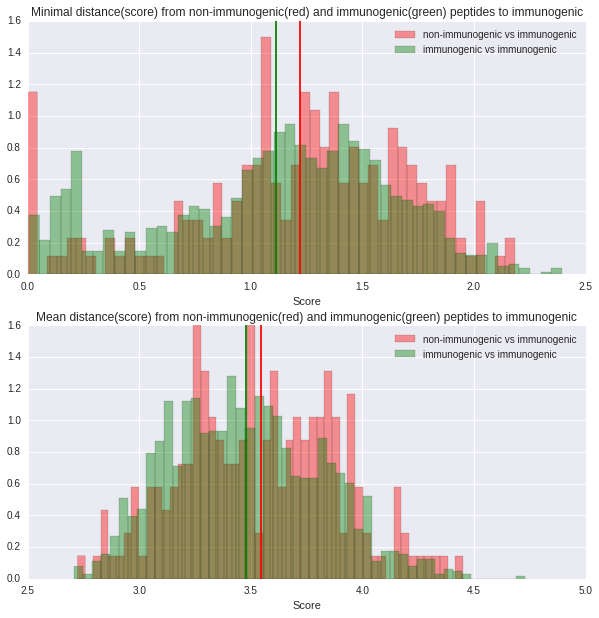

In [8]:
def plot_distribution_immun_vs_nonimmun(FUN):
    FUN_array = []
    for ind in xrange(scores_non_vs_imm.shape[0]):
        array = scores_non_vs_imm[ind]
        try:
            FUN_array.append(FUN(array[~np.isnan(array) & ~np.isinf(array)]))
        except ValueError:
            FUN_array.append(np.nan)
    FUN_array = np.array(FUN_array)
    ax = sns.distplot(FUN_array, bins=50,  kde=False, label='non-immunogenic vs immunogenic', color='red', norm_hist=1)
    plt.axvline(np.mean(FUN_array), c='red')

    FUN_array = []
    for ind in range(scores_imm_vs_imm.shape[0]):
        array = scores_imm_vs_imm[ind]
        try:
            FUN_array.append(FUN(array[~np.isnan(array) & ~np.isinf(array) & (array > 0.00001)]))
        except ValueError:
            FUN_array.append(np.nan)    
    FUN_array = np.array(FUN_array)
    sns.distplot(FUN_array, bins=50, kde=False, label='immunogenic vs immunogenic', color='green', norm_hist=1)
    plt.axvline(np.mean(FUN_array), c='green')
    plt.legend(); plt.xlabel('Score')

plt.figure(figsize=(10, 10))
plt.subplot(211)
plot_distribution_immun_vs_nonimmun(min)
plt.title('Minimal distance(score) from non-immunogenic(red) and immunogenic(green) peptides to immunogenic')

plt.subplot(212)
plot_distribution_immun_vs_nonimmun(np.mean)
plt.title('Mean distance(score) from non-immunogenic(red) and immunogenic(green) peptides to immunogenic')

Below you can choose 'ind' and plot several closest peptides from immunogenoc set to the chosen one

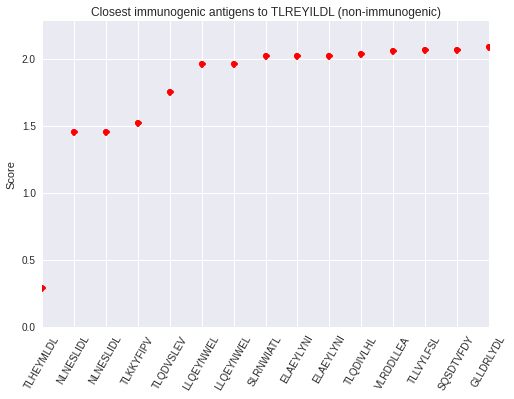

In [18]:
# ind - index of non-immunogenic peptide in peptide_seq_non list
ind = 165

# here we plot 15 closest immunogenic peptides to the non-immunogenic peptide: peptide_seq_non[ind]
point_num = 15
scores = scores_non_vs_imm_sorted[ind][0:point_num];
imm_ind = [[i for i in xrange(scores_non_vs_imm.shape[1]) if scores_non_vs_imm[ind][i] == score][0] for score in scores]
ticks = [peptide_seq_imm[x] for x in imm_ind];
plt.plot(range(point_num), scores, 'ro'); plt.ylabel('Score'); 
ax = plt.xticks(range(point_num), ticks, rotation=60);
axes = plt.gca(); axes.set_ylim([0, max(scores) + 0.2]);
plt.title('Closest immunogenic antigens to ' + peptide_seq_non[ind] + ' (non-immunogenic)');

In [16]:
peptide_df[peptide_df.Peptide == 'TLHEYMLDL']

,Peptide,MHC,Species,Immunogenicity
2047,TLHEYMLDL,HLA-A0201,Homo,1
2048,TLHEYMLDL,HLA-A0201,Mus,0


In [274]:
peptide_df[peptide_df.Peptide.isin(['ISGCYIHFFR', 'SGCYIHFFR', 'MSGCYIHFFR', 'NSGCYIHFFR'])]

,Peptide,MHC,Species,Immunogenicity
866,ISGCYIHFFR,HLA-A1101,Mus,0
1405,MSGCYIHFFR,HLA-A1101,Mus,1
1462,NSGCYIHFFR,HLA-A1101,Mus,1
1749,SGCYIHFFR,HLA-A1101,Mus,1


** In the table above we can see that one marginal letter changed peptide's immunogenicity! Even HLA is the same **

In [277]:
peptide_df[peptide_df.Peptide.isin(['ISSIIRNLPK', 'SSIIRNLPK', 'SSIIRSLPK'])]

,Peptide,MHC,Species,Immunogenicity
873,ISSIIRNLPK,HLA-A1101,Mus,0
1913,SSIIRNLPK,HLA-A1101,Mus,1
1914,SSIIRSLPK,HLA-A1101,Mus,1


** Again single letter changed immunogenicity **

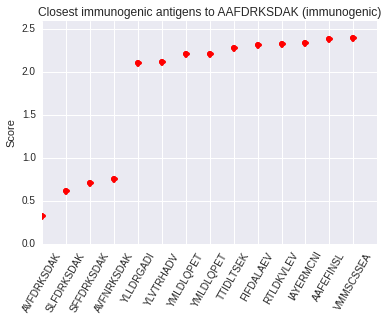

In [265]:
# ind - index of immunogenic peptide in peptide_seq_imm list
ind = 0

# here we plot 15 closest immunogenic peptides to the non-immunogenic peptide: peptide_seq_imm[ind]
point_num = 15
scores = scores_imm_vs_imm_sorted[ind][1:point_num];
imm_ind = [[i for i in xrange(scores_imm_vs_imm.shape[1]) if scores_imm_vs_imm[ind][i] == score][0] for score in scores]
ticks = [peptide_seq_imm[x] for x in imm_ind];
plt.plot(range(point_num - 1), scores, 'ro'); plt.ylabel('Score'); 
plt.xticks(range(point_num), ticks, rotation=60);
axes = plt.gca(); axes.set_ylim([0, max(scores) + 0.2]);
plt.title('Closest immunogenic antigens to ' + peptide_seq_imm[ind] + ' (immunogenic)');

** Now we calculate silhouette considering 2 clusters: non-immunogenic ann immunogenic. **

In [9]:
def silhouette(self_vs_self, self_vs_other):
    single_point_silhouette_sum = 0
    for i in xrange(self_vs_self.shape[0]):
        self_mean = np.mean(self_vs_self[i])
        other_mean = np.mean(self_vs_other[i])
        single_point_silhouette_sum += (other_mean - self_mean) / max(self_mean, other_mean)
    return single_point_silhouette_sum / self_vs_self.shape[0]

In [10]:
# Non-immunogenic silhouette
silhouette(scores_non_vs_non, scores_non_vs_imm)

0.010603333126387823

In [11]:
# Immunogenic silhouette
silhouette(scores_imm_vs_imm, scores_non_vs_imm.T)

0.020158095198508679

** We will try to tune the weights of propeties in the score calculation using gradient descent **

---
For that we will need some useful functions

In [12]:
# just for testing
def minima(*a):
    try:
        g = -600.0 / max(map(abs, a))
    except ZeroDivisionError:
        return a[0]
    den = sum([np.exp(g * x) for x in a])
    num = sum([x * np.exp(g * x) for x in a])
    return num / den

# check 
def check_num(x):
    return (np.isnan(x) or np.isinf(x))

# returns index of min value in the list l
def index_min(l):
    i = 1
    pointer = 0
    minim = l[0]
    while i < len(l):
        if l[i] < minim:
            minim = l[i]
            pointer = i
        i += 1
    return pointer

# returns derivative of min(a[]) function (used when calculating gradient of silhouette)
def min_deriv(a, a_deriv):
    return a_deriv[index_min(a)]

# returns derivative of max(a[]) function
def max_deriv(a, a_deriv):
    i = 1
    pointer = 0
    maxim = a[0]
    while i < len(a):
        if a[i] > maxim:
            maxim = a[i]
            pointer = i
        i += 1
    return a_deriv[pointer]

# tau and psi are lists of average values of distance from each antigen in one cluster to another cluster
# output of this function (psi or tau) depends on the input array 'self_vs_smth'
def tau_psi_calc(weights, self_vs_smth):
    abs_weights = map(np.abs, weights)
    size = len(self_vs_smth[0])
    res  = np.array([0.] * len(self_vs_smth))
    for i in range(len(self_vs_smth)):
        for j in range(size):
            vals = [x[0] + sum([abs_weights[m] * x[m + 1] for m in range(PROP_NUM - 1)]) for x in self_vs_smth[i][j]]
            res[i] += min(vals)
        res[i] /= size
    return res

# returns derivative of tau or psi
def tau_psi_deriv(weights, self_vs_smth):
    abs_weights = map(np.abs, weights)
    sign_weights = map(np.sign, weights)
    size = len(self_vs_smth[0])
    res  = np.array([[0.] * len(self_vs_smth)] * (PROP_NUM - 1), dtype=float)
    for i in range(len(self_vs_smth)):
        for j in range(size):
            vals = [x[0] + sum([abs_weights[m] * x[m + 1] for m in range(PROP_NUM - 1)]) for x in self_vs_smth[i][j]]
            id_min = index_min(vals)
            weight_id = 0
            while weight_id < PROP_NUM - 1:
                min_der = sign_weights[weight_id] * self_vs_smth[i][j][id_min][weight_id + 1]
                res[weight_id, i] = res[weight_id, i] + min_der
                weight_id += 1
        weight_id = 0
        while weight_id < PROP_NUM - 1:
            res[weight_id, i] = res[weight_id, i] / size
            weight_id += 1
    return res
 
# negative gradient of silhouette
def silhouette_grad_negative(weights, self_vs_self, self_vs_other):
    tau = tau_psi_calc(weights, self_vs_other)
    psi = tau_psi_calc(weights, self_vs_self)
    tau_deriv = tau_psi_deriv(weights, self_vs_other)
    psi_deriv = tau_psi_deriv(weights, self_vs_self)
    grad = []
    for weight_id in range(PROP_NUM - 1):
        sil_deriv = i = 0
        tau_deriv_cur = tau_deriv[weight_id]
        psi_deriv_cur = psi_deriv[weight_id]
        while i < len(self_vs_self):
            maxima = max(tau[i], psi[i])
            sil_deriv += (((tau_deriv_cur[i] - psi_deriv_cur[i]) * maxima - \
                          (tau[i] - psi[i]) * max_deriv([tau[i], psi[i]], [tau_deriv_cur[i], psi_deriv_cur[i]])) / \
                          (maxima * maxima))
            i += 1
        grad.append(-sil_deriv / i)
    return np.array(grad)

# negative value of silhouette (we need maximum of silhouette so we minimize its negative value)
def silhouette_value_negative(weights, self_vs_self, self_vs_other):
    tau = tau_psi_calc(weights, self_vs_other)
    psi = tau_psi_calc(weights, self_vs_self)
    return (-np.mean([(i - j)/max(i, j) for i, j in zip(tau, psi)]))

In [339]:
# arrays with values obtained on each iteration
silouette_vals_on_each_iteration = []
weights_on_each_iteration = []

In [334]:
# performs gradient descent
def gradient_descent(weights, alpha=1000., max_iter=50, iter_id=0):
    sil_val = silhouette_value_negative(weights, scores_non_vs_non_exp, scores_non_vs_imm_exp)
    rel_difference = 1.
    if iter_id:
        rel_difference = abs((sil_val - sil_vals[-1]) / sil_vals[-1])
    silouette_vals_on_each_iteration.append(sil_val)
    weights_on_each_iteration.append(weights)
    if iter_id < max_iter and (rel_difference > 0.00001 or np.isnan(rel_difference)):
        new_weights = weights - (alpha * silhouette_grad_negative(weights, scores_non_vs_non_exp, scores_non_vs_imm_exp))
        gradient_descent(new_weights, alpha, max_iter, iter_id+1)
    else:
        return weights

In [335]:
gradient_descent(np.array([2.34870358e-03,   6.18092716e+00]))

In [336]:
f = open('grad_des_info.txt', 'a')
f.write("\n\n==================\n\n")
f.write(str(silouette_vals_on_each_iteration))
f.write("\n")
f.write(str(weights_on_each_iteration))
f.close()

** SO THE BEST SILHOUETTE VALUE OBTAINED VIA GRADIENT DESCENT IS 0.020 - NOT TOO GOOD **

In [31]:
peptide_df_cur = peptide_df[peptide_df.Species == 'Mus']
'''peptide_df_cur = peptide_df_cur[peptide_df_cur.MHC.str.startswith('H-2-D') |
           peptide_df_cur.MHC.str.startswith('H-2-K') |
           peptide_df_cur.MHC.str.startswith('H-2-L') |
           peptide_df_cur.MHC.str.startswith('H-2-Q') |
           peptide_df_cur.MHC.str.startswith('H-2-M') |
           peptide_df_cur.MHC.str.startswith('H-2-T')]'''

peptide_df_cur = peptide_df_cur[peptide_df_cur.MHC.str.startswith('HLA-A') |
           peptide_df_cur.MHC.str.startswith('HLA-B') |
           peptide_df_cur.MHC.str.startswith('HLA-C')]

peptide_df_cur.groupby('MHC').count().iloc[:, 0]

MHC
HLA-A0201    331
HLA-A1101    139
HLA-A2402      6
HLA-B0702     28
HLA-B2705     12
HLA-B3501      7
Name: Peptide, dtype: int64

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


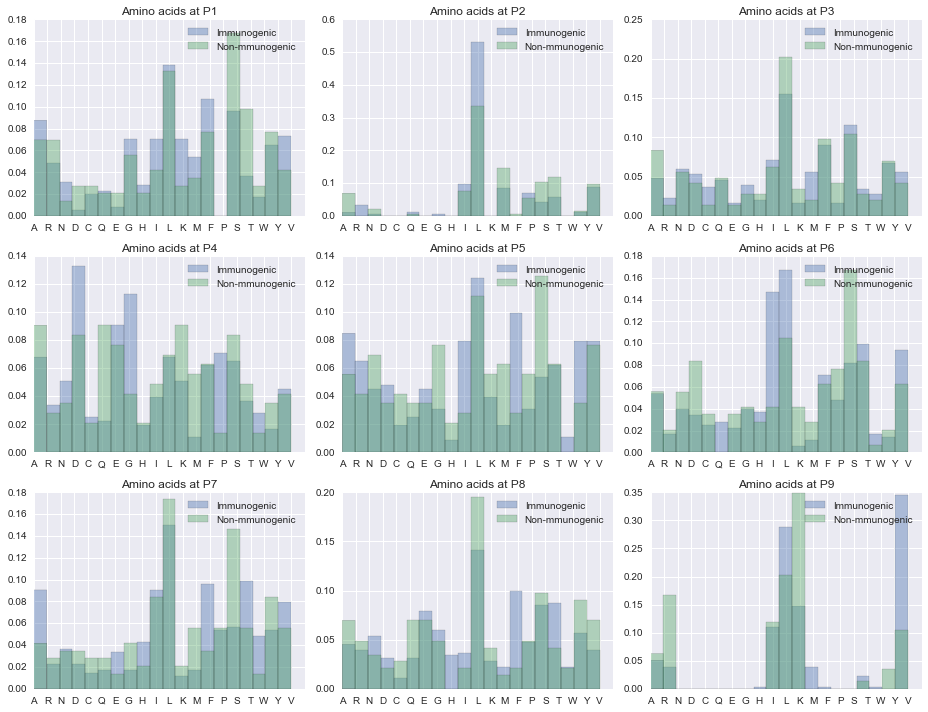

In [32]:
alphabet_dict = dict(zip(alphabet, range(len(alphabet))))

# plot amino acids distribution
def plot_position(*pos):
    sumlist = lambda x, y: x + y
    sns.distplot(reduce(sumlist, list(imm_seq.apply(lambda x: [alphabet_dict[x[i - 1]] for i in pos]))), \
                 bins=len(alphabet), norm_hist=True, kde=False, label='Immunogenic')
    sns.distplot(reduce(sumlist, list(non_seq.apply(lambda x: [alphabet_dict[x[i - 1]] for i in pos]))), \
                 bins=len(alphabet), norm_hist=True, kde=False, label='Non-mmunogenic')
    plt.xticks(range(len(alphabet)), alphabet);
    plt.title('Amino acids at ' + ', '.join(['P'+str(i) for i in pos]))
    plt.legend();

imm_seq = peptide_df_cur[peptide_df.Immunogenicity == 1].Peptide
non_seq = peptide_df_cur[peptide_df.Immunogenicity == 0].Peptide

plt.figure(figsize=(13, 10))
plt.subplot(331); plot_position(1);
plt.subplot(332); plot_position(2);
plt.subplot(333); plot_position(3);
plt.subplot(334); plot_position(4);
plt.subplot(335); plot_position(5);
plt.subplot(336); plot_position(6);
plt.subplot(337); plot_position(7);
plt.subplot(338); plot_position(8);
plt.subplot(339); plot_position(9);
plt.tight_layout();

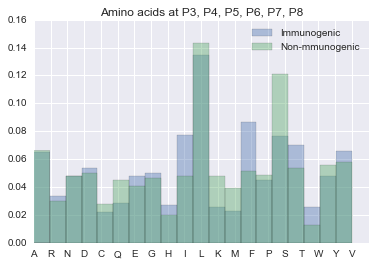

In [33]:
# summary distribution for all positions except anchor
plot_position(3,4,5,6,7,8)

In [34]:
#to_csv = pd.concat([peptide_df_cur.Peptide.apply(lambda x: hydfob[x[i]]) for i in range(9)] + \
#                   [peptide_df_cur.Immunogenicity], axis=1)
#to_csv.columns = ['P1','P2','P3','P4','P5','P6','P7','P8','P9','Immunogenicity']
#to_csv.index = range(to_csv.shape[0])

In [35]:
#to_csv.to_csv('HLA-A0201.csv', index=False)#

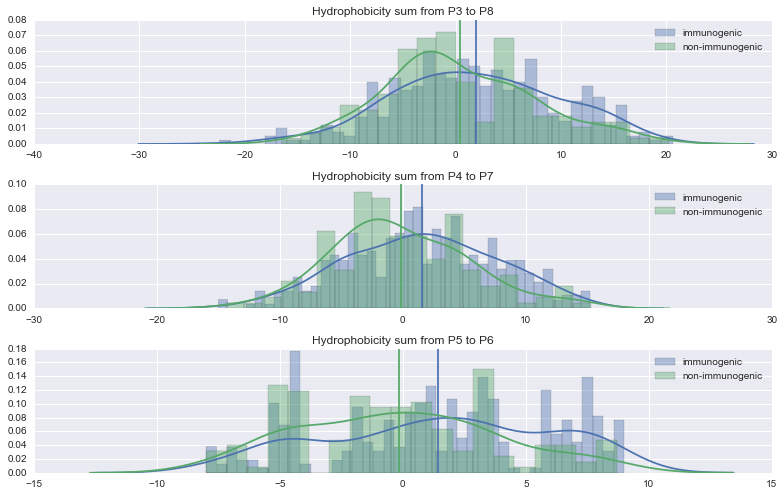

In [36]:
# divide peptide into 3 regions and plot hydrophobicity sum
def hyphob_plot(start, end):
    hyphob_sums = peptide_df_cur.Peptide.apply(lambda x: sum([aa_props.hydrophobicity[x[i]] for i in range(start, end)]))
    ax = sns.distplot(list(hyphob_sums[peptide_df_cur.Immunogenicity == 1]), bins=40, label='immunogenic');
    plt.axvline(hyphob_sums[peptide_df_cur.Immunogenicity == 1].mean(), c=ax.get_lines()[-1].get_color())
    sns.distplot(list(hyphob_sums[peptide_df_cur.Immunogenicity == 0]), bins=20, label='non-immunogenic'); 
    plt.axvline(hyphob_sums[peptide_df_cur.Immunogenicity == 0].mean(), c=ax.get_lines()[-1].get_color())
    plt.title('Hydrophobicity sum from P' + str(start + 1) + ' to P' + str(end));
    plt.legend();

plt.figure(figsize=(11, 7)); 
plt.subplot(311); hyphob_plot(2, 8)
plt.subplot(312); hyphob_plot(3, 7)
plt.subplot(313); hyphob_plot(4, 6)
plt.tight_layout()

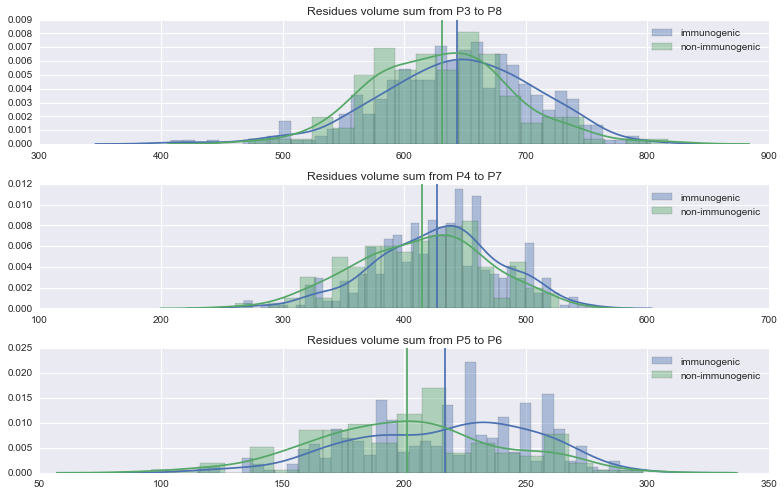

In [37]:
# and volume sum
def volume_plot(start, end):
    hyphob_sums = peptide_df_cur.Peptide.apply(lambda x: sum([aa_props.volume[x[i]] for i in range(start, end)]))
    ax = sns.distplot(list(hyphob_sums[peptide_df_cur.Immunogenicity == 1]), bins=40, label='immunogenic');
    plt.axvline(hyphob_sums[peptide_df_cur.Immunogenicity == 1].mean(), c=ax.get_lines()[-1].get_color())
    sns.distplot(list(hyphob_sums[peptide_df_cur.Immunogenicity == 0]), bins=20, label='non-immunogenic'); 
    plt.axvline(hyphob_sums[peptide_df_cur.Immunogenicity == 0].mean(), c=ax.get_lines()[-1].get_color())
    plt.title('Residues volume sum from P' + str(start + 1) + ' to P' + str(end));
    plt.legend();

plt.figure(figsize=(11, 7))
plt.subplot(311); volume_plot(2, 8)
plt.subplot(312); volume_plot(3, 7)
plt.subplot(313); volume_plot(4, 6)
plt.tight_layout();

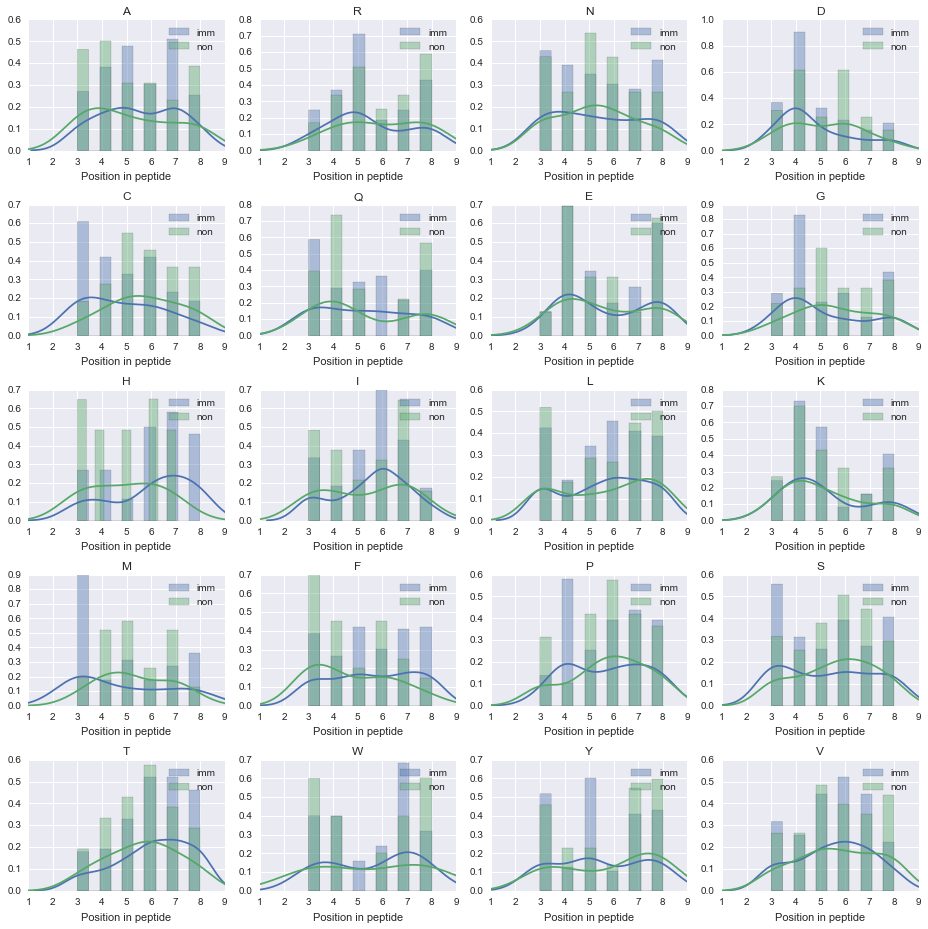

In [38]:
def plot_each_aa(fun, peptides, label='', xlabel='', xlim=False):
    for i in range(20):
        plt.subplot(5, 4, i + 1)
        to_hist = fun(alphabet[i], peptides)
        sns.distplot(to_hist, label=label, bins=11)
        if xlim:
            plt.xlim(xlim);
        if xlabel:
            plt.xlabel(xlabel)
        plt.title(alphabet[i]); plt.legend()
        
def get_poses(aa, peptides):
    res = []
    [[res.append(i + 1) for i in range(2, 8) if aa == peptide[i]] for peptide in peptides]
    return res

plt.figure(figsize=(13, 13))
plot_each_aa(get_poses, imm_seq, label='imm', xlabel='Position in peptide', xlim=[1, 9])
plot_each_aa(get_poses, non_seq, label='non', xlabel='Position in peptide', xlim=[1, 9])
plt.tight_layout()

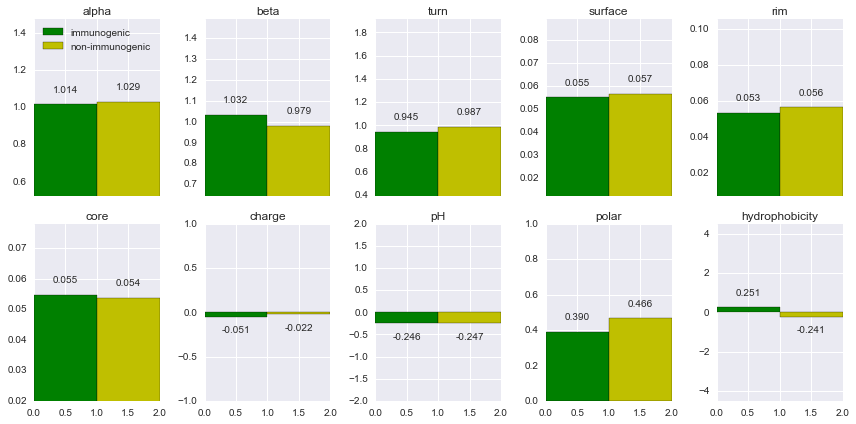

In [40]:
def get_average_property(seqs, pos_list, aa_series):
    return [np.mean([aa_series[seq[pos]] for seq in seqs]) for pos in pos_list]

def get_average_properties(seqs, pos_list, prop_table):
    return prop_table.apply(lambda x: np.mean(get_average_property(seqs, pos_list, x)), axis=0)

pos_range = np.arange(3,6)
average_props = pd.concat([get_average_properties(imm_seq, pos_range, aa_props),
          get_average_properties(non_seq, pos_range, aa_props)], axis=1)
average_props.columns = ['immunogenic', 'non-immunogenic']

fig, ax = plt.subplots(2, 5, sharex=True)
fig.set_size_inches(12, 6)
def property_bars(ax, prop_name, vals_table, prop_table, shift=0):
    width = 1.
    values = vals_table.loc[prop_name, :]
    values_ticks = vals_table.columns
    ids = np.arange(len(values))
    colors = ['g','y','y','b']
    ymax = max(prop_table[prop_name]); ymin = min(prop_table[prop_name]);
    for value, value_id in zip(values, ids):
        ax.bar([value_id], [value], width, color=colors[value_id], label=values_ticks[value_id])
        y_text = value+abs(ymax-ymin)/17. if np.sign(value) > 0 else value-abs(ymax-ymin)/10.
        ax.text(value_id + width/2., y_text, '%.3f' % value, ha='center', va='bottom')
    ax.set_ylim(ymin, ymax)
    #ax.set_xticks(ids + width/2.0)
    ax.set_title(prop_name)
    #ax.set_xticklabels(values_ticks)
    
for i in range(2):
    for j in range(5):
        property_bars(ax[i, j], aa_props.columns[i*5+j], average_props, aa_props)
        if i == 0 and j == 0:
            ax[i, j].legend()
            
plt.tight_layout()
plt.show()

In [15]:
def get_average_property_in_pos_range(peptide, pos_list, prob_series):
    return np.mean([prob_series[peptide[pos]] for pos in pos_list])

def property_table_for_peptide_set(pep_set, pos_list, prop_table):
    return prop_table.apply(lambda col: pep_set.apply(lambda x: get_average_property_in_pos_range(x, pos_list, col)))

X = property_table_for_peptide_set(peptide_df_cur.Peptide, np.arange(3,7), aa_props)
X = sklearn.preprocessing.normalize(X, axis=0)
Y = np.array(peptide_df_cur.Immunogenicity)

#to_weka = pd.DataFrame(X, columns=aa_props.columns)
#to_weka['class'] = np.array(peptide_df_cur.Immunogenicity)
#to_weka.to_csv('peptide_vectors_p4_p6.csv', index=False)

In [37]:
def get_matrix(model, X, Y):
    model.fit(X, Y)
    new_Y = model.predict(X)
    return sklearn.metrics.confusion_matrix(Y, new_Y, [1, 0])[0, 0]

model = sklearn.linear_model.LogisticRegression(C=100000000., random_state=35)
cv = sklearn.cross_validation.KFold(X.shape[0], n_folds=5, shuffle=True, random_state=28)
sklearn.cross_validation.cross_val_score(model, X, Y, cv=cv, scoring=get_matrix)

array([ 58.,  79.,  71.,  72.,  65.])

In [387]:
def peptide_to_props(peptide, pos_list, prop_table):
    return np.concatenate(np.array([prop_table.loc[peptide[pos], :] for pos in pos_list]))

def get_peptides_props_table(pep_seqs, pos_list, prop_table):
    columns = list(product(pos_list, prop_table.columns))
    columns = list(map(lambda x: 'p'+str(x[0]+1)+'-'+x[1], columns))
    table = pd.DataFrame(np.array(list(pep_seqs.apply(lambda x: peptide_to_props(x, pos_list, prop_table)))), columns=columns)
    return table

to_weka = get_peptides_props_table(peptide_df_cur.Peptide, np.arange(3,7), aa_props)
to_weka['class'] = np.array(peptide_df_cur.Immunogenicity)
#to_weka.to_csv('peptide_vectors_p4_p7.csv', index=False)
X = sklearn.preprocessing.normalize(to_weka.iloc[:, :-1], axis=0)
Y = np.array(to_weka.iloc[:, -1])

In [388]:
from pybrain.structure import FullConnection
from pybrain.datasets import ClassificationDataSet
from pybrain.datasets import SupervisedDataSet
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.tools.shortcuts import buildNetwork
from pybrain.utilities import percentError

aa_num = 4
prop_num = 11
net = pybrain.structure.FeedForwardNetwork()
in_layer = pybrain.structure.LinearLayer(prop_num * aa_num, name='in')
first_layer = pybrain.structure.SigmoidLayer(aa_num, name='first')
out_layer = pybrain.structure.SigmoidLayer(2, name='out')
net.addInputModule(in_layer)
net.addModule(first_layer)
net.addOutputModule(out_layer)

in_to_first = [FullConnection(in_layer, first_layer, inSliceFrom=aa_id*prop_num, inSliceTo=(aa_id+1)*prop_num, 
                          outSliceFrom=aa_id, outSliceTo=aa_id+1) for aa_id in range(0, aa_num)]
for i in range(aa_num):
    net.addConnection(in_to_first[i])
in_to_first = FullConnection(in_layer, first_layer)
net.addConnection(in_to_first)
    
first_to_out = FullConnection(first_layer, out_layer)
net.addConnection(first_to_out)
net.sortModules()

#net = buildNetwork(44, 9, 4, 2)

ds = ClassificationDataSet(prop_num*aa_num, 1)
for line in range(X.shape[0]):
    ds.addSample(X[line, :], Y[line])

In [389]:
ds._convertToOneOfMany()

In [390]:
tstdata, trndata = ds.splitWithProportion(0.25)
trainer = BackpropTrainer(net, dataset=trndata, momentum=0.15, verbose=True, learningrate=0.6, weightdecay=0.)

In [391]:
trainer.trainUntilConvergence(maxEpochs=10)

Total error:  0.12185945186
Total error:  0.108377735441
Total error:  0.108017622581
Total error:  0.107728875957
Total error:  0.106345883383
Total error:  0.105297787662
Total error:  0.106743135945
Total error:  0.106298305087
Total error:  0.105442510609
Total error:  0.105177065829
Total error:  0.103780842724
('train-errors:', '[0.121859 , 0.108378 , 0.108018 , 0.107729 , 0.106346 , 0.105298 , 0.106743 , 0.106298 , 0.105443 , 0.105177 , 0.103781 ]')
('valid-errors:', '[0.216767 , 0.089085 , 0.086536 , 0.086138 , 0.083921 , 0.083561 , 0.097392 , 0.093824 , 0.087374 , 0.088193 , 0.083871 , 0.084347 ]')


([0.12185945186033569,
  0.10837773544124248,
  0.10801762258116589,
  0.1077288759570711],
 [0.21676681375820553,
  0.089084756536721335,
  0.086535981044470994,
  0.086138475751332405,
  0.083920581043804052])

In [392]:
trainer_prev

<BackpropTrainer 'BackpropTrainer-537'>

In [393]:
from pybrain.utilities           import percentError

trnresult = percentError(trainer.testOnClassData(dataset=trndata), trndata['target'])
tstresult = percentError(trainer.testOnClassData(dataset=tstdata), tstdata['target'])

print("epoch: %4d" % trainer.totalepochs, "  train error: %5.2f%%" % trnresult, "  test error: %5.2f%%" % tstresult)

epoch:   11   train error:  0.25%   test error:  0.77%


In [394]:
sum(tstdata['target'][:, 0]) / len(tstdata['target'])

0.30769230769230771

In [396]:
sum(trainer.testOnClassData(return_targets=True)[0]) / len(trndata['target'])

1.0

In [399]:
net.activateOnDataset(tstdata)

array([[ 0.23276439,  0.75905749],
       [ 0.23853978,  0.75331568],
       [ 0.27567972,  0.74981205],
       [ 0.21313363,  0.75327823],
       [ 0.26056686,  0.74581187],
       [ 0.24802095,  0.74749112],
       [ 0.237702  ,  0.77574742],
       [ 0.22072175,  0.75505291],
       [ 0.26140454,  0.73950774],
       [ 0.22332231,  0.74799203],
       [ 0.2414311 ,  0.76935014],
       [ 0.24519289,  0.75669817],
       [ 0.23879965,  0.75001168],
       [ 0.25856355,  0.74975308],
       [ 0.22492421,  0.75915143],
       [ 0.25365595,  0.75308832],
       [ 0.26140454,  0.73950774],
       [ 0.25664522,  0.73955187],
       [ 0.24026366,  0.74787536],
       [ 0.25396377,  0.73405345],
       [ 0.23165604,  0.75516093],
       [ 0.26533976,  0.74540062],
       [ 0.24636282,  0.73743815],
       [ 0.27356606,  0.75529402],
       [ 0.22561389,  0.73955052],
       [ 0.22845384,  0.76752811],
       [ 0.22855482,  0.75495301],
       [ 0.22259132,  0.77477786],
       [ 0.2453095 ,